<a href="https://colab.research.google.com/github/Cheer3142/BEARING-ONLY-LOCALIZATION-IMPLEMENT/blob/main/Networked_pointing_system_Bearing_only_target_localization_and_pointing_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import networkx as nx

## Define System Parameters

In [25]:
# Agent and target positions
p_agents = np.array([
    [2, 4],  # SA1
    [4, 4],  # SA2
    [5, 2],  # NSA1
    [4, 1],  # NSA2
    [2, 1],  # NSA3
    [1, 2]   # NSA4
])

q_target = np.array([3, 6])

# Communication topology (adjacency matrix for NSAs)
A_n = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0]
])

# Input matrix B (NSA connections to SAs)
B = np.array([
    [1, 0],  # NSA1 connected to SA1
    [1, 0],  # NSA2 connected to SA1
    [0, 1],  # NSA3 connected to SA2
    [0, 1]   # NSA4 connected to SA2
])

# # Estimator gains
# k12, k21 = 1.0, 1.0
# alpha = 1.0  # NSA consensus gain
# beta = 1.0   # NSA-SA connection gain

# Improved gains for better convergence
k12, k21 = 2.0, 2.0  # Increased SA gains
alpha = 2.0  # Increased NSA consensus gain
beta = 2.0   # Increased NSA-SA connection gain

# Controller gain
controller_gain = 2.0

# Simulation parameters
dt = 0.1
T = 20
steps = int(T / dt)

## Initialize State Variables

In [26]:
n_agents = p_agents.shape[0]
n_sa = 2
n_nsa = n_agents - n_sa

# Initial estimates: same as agent positions (ensure float dtype)
q_hat = p_agents.copy().astype(float)  # Add .astype(float) here

# Initial headings: random unit vectors
h = np.random.randn(n_agents, 2)
h = h / np.linalg.norm(h, axis=1, keepdims=True)

# Store history for plotting
q_hat_history = np.zeros((steps, n_agents, 2))
h_history = np.zeros((steps, n_agents, 2))
error_history = np.zeros((steps, n_agents, 2))
pointing_error_history = np.zeros((steps, n_agents))

## SA and NSA Estimator

In [27]:
def orthogonal_projection(v):
    """Compute orthogonal projection matrix for vector v."""
    v = v.reshape(-1, 1)
    return np.eye(2) - v @ v.T

def bearing_vector(p, q):
    """Compute bearing vector from p to q."""
    r = q - p
    return r / np.linalg.norm(r)

def pointing_error(h, p, q):
    """Compute pointing error: angle between heading and target direction."""
    target_dir = q - p
    target_dir = target_dir / np.linalg.norm(target_dir)
    return np.arccos(np.clip(h @ target_dir, -1, 1))

def sa_estimator(i, q_hat_sa, z_sa, p_sa):
    """Update SA estimate using Eq. 7a."""
    if i == 0:
        k = k12
        q_hat_other = q_hat_sa[1]
    else:
        k = k21
        q_hat_other = q_hat_sa[0]

    M_z = orthogonal_projection(z_sa[i])
    dq = k * (q_hat_other - q_hat_sa[i]) - M_z @ (q_hat_sa[i] - p_sa[i])
    return dq

def nsa_estimator(i, q_hat_nsa, q_hat_sa, A_n, B):
    """Update NSA estimate using Eq. 7b."""
    # Consensus term (NSA-NSA)
    consensus = 0
    for j in range(n_nsa):
        consensus += A_n[i, j] * (q_hat_nsa[j] - q_hat_nsa[i])

    # SA influence term (NSA-SA)
    sa_influence = 0
    for j in range(n_sa):
        sa_influence += B[i, j] * (q_hat_sa[j] - q_hat_nsa[i])

    return consensus + sa_influence

def pointing_controller(h, p, q_hat):
    """Update heading using Eq. 9 with gain."""
    M_h = orthogonal_projection(h)
    dh = controller_gain * M_h @ (q_hat - p)  # Added gain
    return dh

## Main Simulation Loop

In [28]:
for step in range(steps):
    # Separate SA and NSA estimates
    q_hat_sa = q_hat[:n_sa].copy()  # Add .copy() to avoid reference issues
    q_hat_nsa = q_hat[n_sa:].copy()

    # SA bearing measurements
    z_sa = np.array([bearing_vector(p_agents[i], q_target) for i in range(n_sa)])

    # Update SA estimates
    for i in range(n_sa):
        dq_sa = sa_estimator(i, q_hat_sa, z_sa, p_agents[:n_sa])
        q_hat_sa[i] = q_hat_sa[i] + dq_sa * dt  # Use explicit assignment

    # Update NSA estimates
    for i in range(n_nsa):
        dq_nsa = nsa_estimator(i, q_hat_nsa, q_hat_sa, A_n, B)
        q_hat_nsa[i] = q_hat_nsa[i] + dq_nsa * dt  # Use explicit assignment

    # Combine estimates
    q_hat = np.vstack([q_hat_sa, q_hat_nsa])

    # Update headings for all agents
    for i in range(n_agents):
        dh = pointing_controller(h[i], p_agents[i], q_hat[i])
        h[i] = h[i] + dh * dt  # Use explicit assignment
        h[i] = h[i] / np.linalg.norm(h[i])  # Normalize

    # Store history
    q_hat_history[step] = q_hat
    h_history[step] = h
    error_history[step] = q_target - q_hat
    pointing_error_history[step] = [pointing_error(h[i], p_agents[i], q_target)
                                   for i in range(n_agents)]

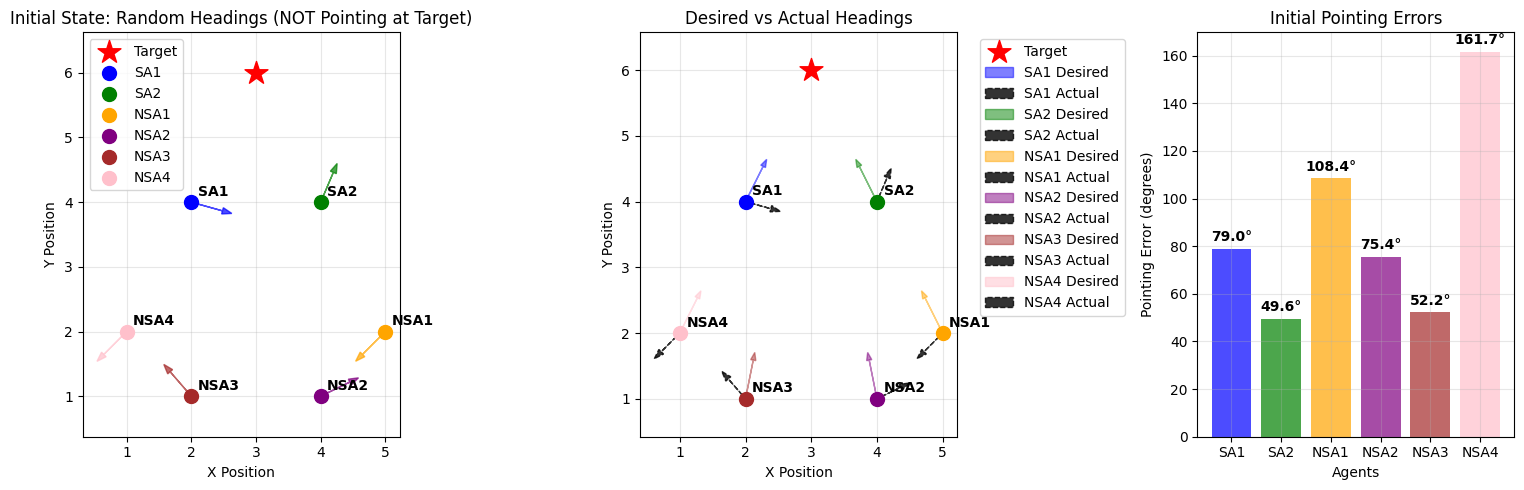

INITIAL STATE ANALYSIS - RANDOM HEADINGS

AGENT HEADING ANALYSIS:
Agent     Current Heading     Heading Angle  Desired Angle  Error
-----------------------------------------------------------------
SA1      [ 0.96, -0.27]     344.4°        63.4°     79.0°
SA2      [ 0.39,  0.92]      67.0°       116.6°     49.6°
NSA1     [-0.71, -0.71]     225.0°       116.6°    108.4°
NSA2     [ 0.90,  0.44]      25.9°       101.3°     75.4°
NSA3     [-0.65,  0.76]     130.9°        78.7°     52.2°
NSA4     [-0.71, -0.71]     225.1°        63.4°    161.7°

SUMMARY:
Average pointing error: 87.7°
Maximum pointing error: 161.7°
Minimum pointing error: 49.6°

GOAL OF THE SIMULATION:
The controller should rotate all agents' headings to point at the target
(reduce all pointing errors to near 0°)


In [31]:
# Create figure for initial state visualization
plt.figure(figsize=(15, 5))

# RE-INITIALIZE with truly random headings (not pointing at target)
np.random.seed(42)  # For reproducible random results
h_random = np.random.randn(n_agents, 2)
h_random = h_random / np.linalg.norm(h_random, axis=1, keepdims=True)

# Plot 1: Initial Positions and RANDOM Headings
plt.subplot(1, 3, 1)
plt.title('Initial State: Random Headings (NOT Pointing at Target)')

# Plot target
plt.scatter(q_target[0], q_target[1], c='red', marker='*', s=300, label='Target', zorder=5)

# Plot agents and their RANDOM headings
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']
agent_labels = ['SA1', 'SA2', 'NSA1', 'NSA2', 'NSA3', 'NSA4']

for i in range(n_agents):
    # Agent position
    plt.scatter(p_agents[i, 0], p_agents[i, 1], c=colors[i], s=100, label=agent_labels[i], zorder=4)

    # RANDOM heading vector (arrow)
    plt.arrow(p_agents[i, 0], p_agents[i, 1],
              h_random[i, 0] * 0.5, h_random[i, 1] * 0.5,  # Scale arrows for better visualization
              head_width=0.1, head_length=0.15, fc=colors[i], ec=colors[i],
              alpha=0.7, zorder=3)

    # Agent label
    plt.text(p_agents[i, 0] + 0.1, p_agents[i, 1] + 0.1, agent_labels[i],
             fontsize=10, fontweight='bold')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 2: Desired vs Actual Headings
plt.subplot(1, 3, 2)
plt.title('Desired vs Actual Headings')

# Plot target and agent positions
plt.scatter(q_target[0], q_target[1], c='red', marker='*', s=300, label='Target', zorder=5)

for i in range(n_agents):
    # Agent position
    plt.scatter(p_agents[i, 0], p_agents[i, 1], c=colors[i], s=100, zorder=4)

    # DESIRED heading (pointing to target)
    desired_dir = bearing_vector(p_agents[i], q_target)
    plt.arrow(p_agents[i, 0], p_agents[i, 1],
              desired_dir[0] * 0.6, desired_dir[1] * 0.6,
              head_width=0.08, head_length=0.12, fc=colors[i], ec=colors[i],
              linestyle='-', alpha=0.5, zorder=2, label=f'{agent_labels[i]} Desired')

    # ACTUAL heading (random)
    plt.arrow(p_agents[i, 0], p_agents[i, 1],
              h_random[i, 0] * 0.4, h_random[i, 1] * 0.4,
              head_width=0.1, head_length=0.15, fc='black', ec='black',
              linestyle='--', alpha=0.8, zorder=3, label=f'{agent_labels[i]} Actual')

    # Agent label
    plt.text(p_agents[i, 0] + 0.1, p_agents[i, 1] + 0.1, agent_labels[i],
             fontsize=10, fontweight='bold')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 3: Initial Pointing Errors
plt.subplot(1, 3, 3)
plt.title('Initial Pointing Errors')

initial_pointing_errors = [pointing_error(h_random[i], p_agents[i], q_target) for i in range(n_agents)]
initial_pointing_errors_deg = [np.degrees(error) for error in initial_pointing_errors]

x_pos = np.arange(n_agents)
bars = plt.bar(x_pos, initial_pointing_errors_deg, color=colors, alpha=0.7)

plt.xlabel('Agents')
plt.ylabel('Pointing Error (degrees)')
plt.xticks(x_pos, agent_labels)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, error_deg in zip(bars, initial_pointing_errors_deg):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{error_deg:.1f}°', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("=" * 70)
print("INITIAL STATE ANALYSIS - RANDOM HEADINGS")
print("=" * 70)

print("\nAGENT HEADING ANALYSIS:")
print("Agent     Current Heading     Heading Angle  Desired Angle  Error")
print("-" * 65)

for i, label in enumerate(agent_labels):
    current_angle = np.degrees(np.arctan2(h_random[i, 1], h_random[i, 0])) % 360
    desired_dir = bearing_vector(p_agents[i], q_target)
    desired_angle = np.degrees(np.arctan2(desired_dir[1], desired_dir[0])) % 360
    error_deg = initial_pointing_errors_deg[i]

    print(f"{label:4}     [{h_random[i, 0]:5.2f}, {h_random[i, 1]:5.2f}]   {current_angle:7.1f}°     {desired_angle:7.1f}°    {error_deg:5.1f}°")

print(f"\nSUMMARY:")
print(f"Average pointing error: {np.mean(initial_pointing_errors_deg):.1f}°")
print(f"Maximum pointing error: {np.max(initial_pointing_errors_deg):.1f}°")
print(f"Minimum pointing error: {np.min(initial_pointing_errors_deg):.1f}°")

print(f"\nGOAL OF THE SIMULATION:")
print("The controller should rotate all agents' headings to point at the target")
print("(reduce all pointing errors to near 0°)")

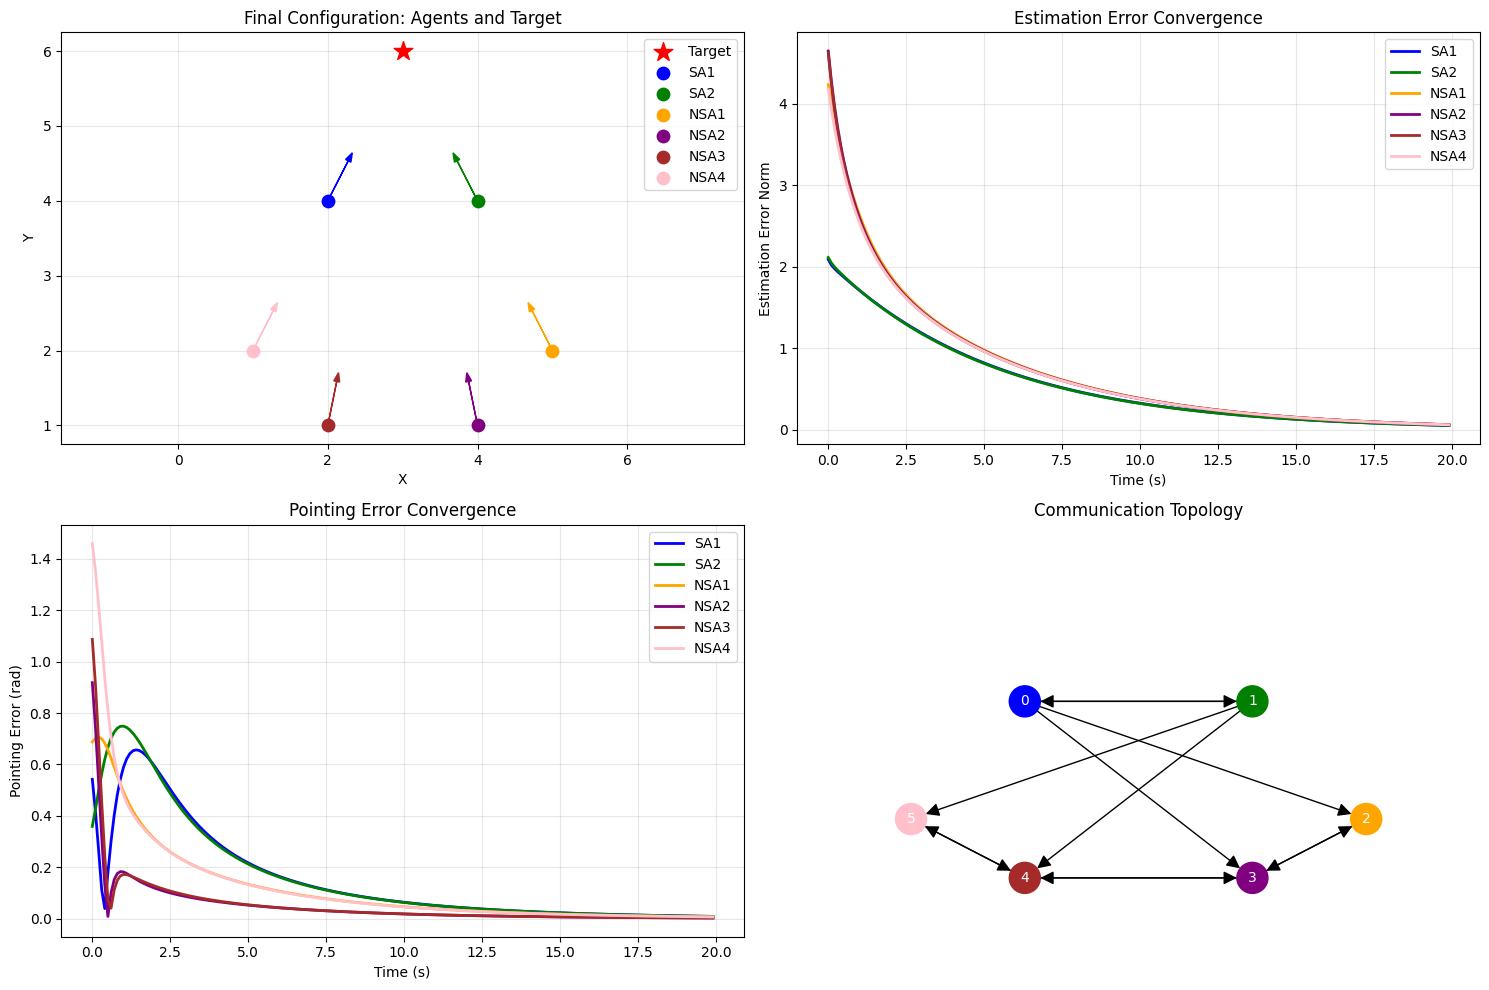

Final Results:
----------------------------------------
Estimation Errors:
  SA1: 0.0517
  SA2: 0.0512
  NSA1: 0.0614
  NSA2: 0.0607
  NSA3: 0.0603
  NSA4: 0.0603

Pointing Errors (rad):
  SA1: 0.0089
  SA2: 0.0088
  NSA1: 0.0069
  NSA2: 0.0028
  NSA3: 0.0028
  NSA4: 0.0068

✓ SUCCESS: All agents pointing at target (max error: 0.0089 rad)


In [45]:
# Create figure for visualization
plt.rcParams['figure.figsize'] = [15, 10]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# Use same colors as initial plot
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']
agent_labels = ['SA1', 'SA2', 'NSA1', 'NSA2', 'NSA3', 'NSA4']

# Plot 1: Final Configuration
ax1.set_title('Final Configuration: Agents and Target')
ax1.scatter(q_target[0], q_target[1], c='red', marker='*', s=200, label='Target', zorder=5)

for i in range(n_agents):
    ax1.scatter(p_agents[i, 0], p_agents[i, 1], c=colors[i], label=agent_labels[i], s=80, zorder=4)
    # Plot heading vector (scaled for better visibility)
    ax1.arrow(p_agents[i, 0], p_agents[i, 1],
              h[i, 0] * 0.6, h[i, 1] * 0.6,
              head_width=0.08, head_length=0.12, fc=colors[i], ec=colors[i], zorder=3)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Plot 2: Estimation Error Convergence
ax2.set_title('Estimation Error Convergence')
time = np.arange(steps) * dt

for i in range(n_agents):
    error_norm = np.linalg.norm(error_history[:, i, :], axis=1)
    ax2.plot(time, error_norm, color=colors[i], label=agent_labels[i], linewidth=2)

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Estimation Error Norm')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Pointing Error Convergence
ax3.set_title('Pointing Error Convergence')

for i in range(n_agents):
    ax3.plot(time, pointing_error_history[:, i], color=colors[i], label=agent_labels[i], linewidth=2)

ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Pointing Error (rad)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Communication Topology
ax4.set_title('Communication Topology')

G = nx.DiGraph()

# Add nodes
for i, label in enumerate(agent_labels):
    G.add_node(i, pos=p_agents[i], label=label)

# Add edges (NSA-NSA)
for i in range(n_nsa):
    for j in range(n_nsa):
        if A_n[i, j] > 0:
            G.add_edge(i+n_sa, j+n_sa)

# Add edges (NSA-SA)
for i in range(n_nsa):
    for j in range(n_sa):
        if B[i, j] > 0:
            G.add_edge(j, i+n_sa)

# Add SA-SA connection
G.add_edge(0, 1)
G.add_edge(1, 0)

# Draw graph
pos = {i: p_agents[i] for i in range(n_agents)}
nx.draw(G, pos, ax=ax4, with_labels=True, node_color=colors,
        node_size=500, font_size=10, font_color ="white", arrows=True, arrowsize=20)

ax4.set_xlim(0, 6)
ax4.set_ylim(0, 7)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
final_est_error = np.linalg.norm(error_history[-1], axis=1)
final_pointing_error = pointing_error_history[-1]

print("Final Results:")
print("-" * 40)
print("Estimation Errors:")
for i, label in enumerate(agent_labels):
    print(f"  {label}: {final_est_error[i]:.4f}")

print("\nPointing Errors (rad):")
for i, label in enumerate(agent_labels):
    print(f"  {label}: {final_pointing_error[i]:.4f}")

# Check if simulation was successful
max_final_pointing_error = np.max(final_pointing_error)
if max_final_pointing_error < 0.1:
    print(f"\n✓ SUCCESS: All agents pointing at target (max error: {max_final_pointing_error:.4f} rad)")
else:
    print(f"\n✗ NEEDS IMPROVEMENT: Large pointing errors (max: {max_final_pointing_error:.4f} rad)")